In [1]:
import os, os.path
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0' 
os.environ["CUDA_VISIBLE_DEVICES"]=""
tf_device='/gpu:0'
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.get_logger().setLevel('INFO')
tf.keras.backend.floatx()
from collections import deque
import itertools
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from libs.utils import *
from libs.generate_boxes import *
from libs.dqn import *

num_episode = 1500
global_step = 0
allow_skip = False
tr_l, h_fill, tr_r, avg_loss_l,history_eps,used_boxes_eps  = [],[],[],[],[],[]
N_MDD = 7

num_max_boxes = N_MDD
num_max_remain = num_max_boxes

env=Bpp3DEnv()

In [2]:
K = 1 # 선택할 박스 수
n_candidates = 5# K보다 커야 함

In [71]:
%matplotlib inline
boxes_multi,gt_pos = generation_3dbox_random(case_size=[[20,20,20]], min_s = 1, N_mdd=N_MDD)#, is_prediv='h')

# for e in range(1,num_episode):
st=time.time()

env.reset()# env 초기화
print(np.sum(env.container_s))
done = False
step = 0
history, h_load, h_remain_size, h_load_size = [],[],[],[]
t_history, t_load, t_remain_size, t_load_size = [],[],[],[]
used_boxes, pred_pos = [],[]

#boxes_all = np.array(boxes_multi)[e%100].copy()
boxes_all = np.array(boxes_multi)[0].copy()
r_boxes = boxes_all.copy() #single case

while not done:#중박스에 대해 반복##############
    state = env.container_s.copy()
    state_h = env.container_h.copy()
    step += 1
    k = min(K, len(r_boxes))
    selected = cbn_select_boxes(r_boxes[:n_candidates], k) #r_boxes의 앞에서부터 n_candidates 만큼의 상자 중 k개의 중박스 선택 
    #selected = r_boxes.reshape((-1,1,3))
    s_order = get_selected_order(selected, k)

    num_loaded_c, loading_size_c, loading_pos_c, next_state_c, next_h_c, loaded_mh_c = get_selected_location(s_order, state, state_h, env.height)
    in_state, in_r_boxes, in_loading = raw2input(state_h, len(num_loaded_c), r_boxes, num_max_remain, K, loading_size_c, env.height) # input 변환 

    # action 선택 수가 1일 때 action 스킵
    if len(num_loaded_c) == 1:
        action_idx = 0
    else: # 선택 가능
        # action 실행
        action_idx = random.randrange(len(num_loaded_c))
        
    # print('===============================')
    # plt.imshow(loaded_mh_c[action_idx][...,0], vmin=0, vmax=1)
    # plt.show()
    # plt.imshow(loaded_mh_c[action_idx][...,1], vmin=0, vmax=1)
    # plt.show()
    # plt.imshow(in_state[0,:,:,0], vmin=0, vmax=1)
    # plt.show()
    # vis_box(loading_size_c[action_idx], loading_pos_c[action_idx])
    # if len(used_boxes)>0: vis_box(used_boxes, pred_pos)
    # print(loaded_mh_c[action_idx][...,0])
    # print(loaded_mh_c[action_idx][...,1])
    # plt.imshow(next_state_c[action_idx], vmin=0, vmax=20)
    # plt.show()
    # plt.imshow(next_h_c[action_idx], vmin=0, vmax=20)
    # plt.show()

    # 다음 step ########################
    # env의 다음 state
    env.step(next_state_c[action_idx], next_h_c[action_idx]) 
    # r_boxes 업데이트
    num_loaded_box = num_loaded_c[action_idx]
    if num_loaded_box != 0: # 적입된 박스가 하나 이상 있는 경우 -> append
        new_used_boxes = loading_size_c[action_idx] # 기존 적재 박스, 기존 + 새 박스 -> 새로 적재된 박스 
        r_boxes = get_remain(new_used_boxes, r_boxes) # 남은 박스 업데이트 = 남은 박스 - 새로 적재 박스
        # 사용된 박스, 위치 업데이트
        used_boxes = used_boxes + loading_size_c[action_idx] #사용된 박스 업데이트
        pred_pos = pred_pos + loading_pos_c[action_idx] #예측된 위치 업데이트   

    else: # 적입된 박스가 없을 경우 - action = zero, state=t_state, 해당 박스들 모두 스킵
        r_boxes = get_remain(s_order[action_idx], r_boxes) # 남은 박스 업데이트 = 남은 박스 - 선택된 박스
    
     
    
    if len(r_boxes) == 0 or np.sum(env.container_h != env.height) == 0: # 더 이상 적입할 적입할 수 없는 경우(박스 다 사용 or 다 채워짐)
        done = True              

print("time: {:.3f}".format(time.time()-st), 'fill', env.terminal_reward())


0.0
time: 0.022 fill 0.6


<IPython.core.display.Javascript object>


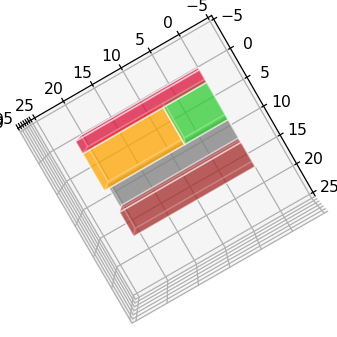

In [72]:
%matplotlib notebook
vis_box(used_boxes, pred_pos)

In [ ]:
# state = np.zeros((20,20))
# state_h = np.zeros((20,20))
# env_h = 20
# pos_pred_tmp = []
# for box in used_boxes:
#     print('==============',box)
#     env_l, env_b = state_h.shape
#     bxl, bxb, bxh = box[0], box[1], box[2]
#     f_loc = np.where(state_h + bxh <= env_h) # 환경의 높이보다 state 작은 위치
#     f_upleft = np.stack([f_loc[0], f_loc[1]], axis=-1) # array 형태로 변환
#     f_upleft = f_upleft[f_upleft[:,0] + bxl  <= env_l ] # row 넘어가면 삭제
#     f_upleft = f_upleft[f_upleft[:,1] + bxb <= env_b ] # columns 넘어가면 삭제
#     area = np.array([state_h[i:i+bxl, j:j+bxb] for i,j in f_upleft])
#     loc_xyz = []
#     if len(f_upleft) > 0 and len(area)>0:
#         #print(area.shape, f_upleft.shape, state_h.shape)
#         area = np.max(area, axis=(1,2)) # 적입할 수 있는 위치의 높이
#         f_upleft = f_upleft[area+ bxh <= env_h] # 높이 넘으면 삭제
#         area = area[area+ bxh <= env_h]
#     if len(f_upleft) > 0 and len(area)>0:
#         #f_upleft = f_upleft[area == np.min(area)] #가장 낮게 적입할 수 있는 위치
#         #z =  state_h[f_upleft[:,0], f_upleft[:, 1]] # z 좌표
#         loc_xyz = np.concatenate([f_upleft, area[:, np.newaxis]], axis = -1) #xyz 좌표
#         loc_xyz = loc_xyz[np.lexsort((loc_xyz[:,1],loc_xyz[:,0],loc_xyz[:,2]))] #하나 선택
#         loc_xyz = loc_xyz[0].astype('int')
    
#     fixed_xyz = loc_xyz.copy()
    
#     if len(fixed_xyz) != 0:
#         next_state, next_state_h = get_next_state(state, state_h, fixed_xyz[:2], box[0], box[1], box[2])
#         state = next_state.copy() 
#         state_h = next_state_h.copy() 
#         pos_pred_tmp.append(fixed_xyz)
    
    
#     print(loc_xyz)
# for i in range(1,len(used_boxes)+1):
#     vis_box(used_boxes[:i], pos_pred_tmp[:i])